<a href="https://colab.research.google.com/github/imran9891/TensorFlow/blob/main/09_Skimlit_NLP_Milestone_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: Skimlit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is availabel here: https://arxiv.org/abs/1612.05251

**Resource:** If we want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the Github: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb


## Confirm access to GPU

In [1]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Getting the data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authords Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [3]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


## Becoming one with the data

In [5]:
# Start our experiments using the 20k dataset with numbers replaced by the '@' sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

So, with that in mind, let's write a function to read in all of the lines of a target text file.

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filenames.
  """
  with open(filename, mode="r") as f:
    return f.readlines()

In [8]:
# Let's read in the training lines
train_lines= get_lines(filenames[1]) # read the lines within the training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

# Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number':0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n",
   'total_lines': 11},
   ...]
```

In [10]:
# Creating a function to convert text into dictionaries
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Args:
    filename: Takes in filename, reads it contents and sorts through each line,
    extracting things like the target label, the text of the sentence, how many
    sentences are in the current abstract and what sentence number the target
    line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line is an ID line
      abstract_id = line 
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
    
      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line apper in the abstract
        line_data["total line"] = len(abstract_line_split)-1 # how many total lines are there in the target abstract?  (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [11]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(filenames[1])
val_samples = preprocess_text_with_line_numbers(filenames[2])
test_samples = preprocess_text_with_line_numbers(filenames[0])
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 497 ms, sys: 68.6 ms, total: 566 ms
Wall time: 570 ms


In [12]:
# Check the first abstract of the training data
train_samples[:20]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total line': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total line': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total line': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total line': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures included th

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [14]:
train_df.head(15)

,target,text,line_number,total line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [15]:
# Check the distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

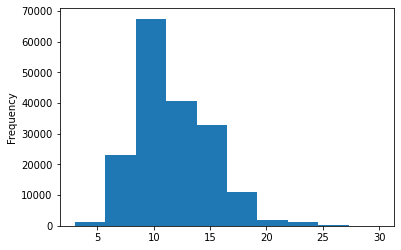

In [16]:
# Check the length of different lines
train_df["total line"].plot.hist();

## Get list of sentences

In [17]:
# Getting a list of sentences from Dataframes
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [33]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(X=train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(X=val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(X=test_df["target"].to_numpy().reshape(-1,1))

# Check what one hot encoded label look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [78]:
train_df["target"].to_numpy()

array(['OBJECTIVE', 'METHODS', 'METHODS', ..., 'RESULTS', 'CONCLUSIONS',
       'CONCLUSIONS'], dtype=object)

## Label encode labels

In [41]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [42]:
# Get class names and number of classes from label encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

As usual, we're going to be trying out a bunch of different models and seeing which one works best. And as always, we're going to start with a baseline (TF_IDF Multinomial Naive Bayes Classifier)

1. Model_0: Naive Bayes with TF-IDF encoder (baseline)
2. Model_1: Conv1D with token embeddings
3. Model_2: TensorFlow Hub Pretrained Feature Extractor
4. Model_3: Conv_1D with character embeddings
5. Model_4: Pretrained token embeddings (same as 2) + character embeddings (same as 3)
6. Model_5: Pretrained token embeddings + character embeddings + positional embeddings

## Model 0: Baseline model (Term Frequency — Inverse Document Frequency)

For more knowledge on TF-IDF see: https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])
model_0.fit(train_sentences,
            train_labels_encoded)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [49]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [74]:
# Make predictions and return results using our baseline model
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(model,y_true):
  results = {}
  preds = model.predict(val_sentences)
  acc_score = accuracy_score(y_true,preds)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,preds,average="weighted")
  results["accuracy"] = acc_score*100
  results["precision"] = model_precision
  results["recall"] = model_recall
  results["f1-score"] = model_f1
  return results

In [75]:
# Check baseline results
baseline_results = calculate_results(model_0,val_labels_encoded)
baseline_results

{'accuracy': 72.1832384482987,
 'f1-score': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

## Tokenization

In [118]:
# How long is each sentence on an average?
import numpy as np
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

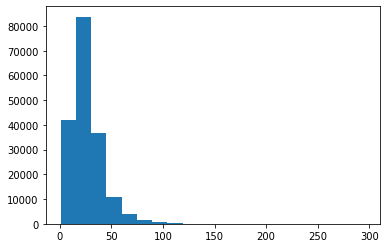

In [119]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20);

In [120]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len # all sentences are under 55 tokens in length

55

In [122]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [123]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_vocab_length = 68000 # taken from paper
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=output_seq_len,
                                    pad_to_max_tokens=True)

In [124]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [134]:
# Test out text vectorizer on random sentences
import random
random_sentence = random.choice(train_sentences)
print(f"Text:\n{random_sentence}\n\nLength of text: {len(random_sentence.split())} \n\nText Vectorizer output:\n {text_vectorizer([random_sentence])}")

Text:
a successful extubation was defined as sb for > @ h following endotracheal tube removal .

Length of text: 16 

Text Vectorizer output:
 [[   8  845 1908   10  472   25 2733   11  196  240 2867 1410 1279    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [135]:
# How many words in vocabulary, most common words, most least common words?
words_in_vocab = text_vectorizer.get_vocabulary()
print(f"Total words in vocabulary: {len(words_in_vocab)}\n10 Most common words: {words_in_vocab[:10]}\n10 Most Least Common Words: {words_in_vocab[-10:]}")

Total words in vocabulary: 64841
10 Most common words: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
10 Most Least Common Words: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [137]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create custom text embedding

In [141]:
# Create token embedding layer (feature-vector matrix representation)
from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim=max_vocab_length, # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence length (save space)
                               input_length=output_seq_len,
                               name="token_embedding")

In [143]:
# Show example embedding
print(f"Sentence before vectorization:\n {random_sentence}\n")
vectorized_sentence = text_vectorizer([random_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedding_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedding_sentence}\n")
print(f"Embedded sentence shape: {embedding_sentence.shape}")

Sentence before vectorization:
 a successful extubation was defined as sb for > @ h following endotracheal tube removal .

Sentence after vectorization (before embedding):
 [[   8  845 1908   10  472   25 2733   11  196  240 2867 1410 1279    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[ 2.7395178e-02 -2.5791932e-02  8.8251457e-03 ...  1.5938733e-02
   -3.0736197e-02 -8.4667429e-03]
  [-2.3232773e-04 -6.2908418e-03  3.6211025e-02 ...  1.3068054e-02
   -2.0474458e-02 -2.4219966e-02]
  [-4.0899266e-02  3.5400059e-02  8.3324313e-03 ... -3.2665253e-02
    4.0066097e-02  3.2368187e-02]
  ...
  [ 2.3429636e-02  4.3168664e-03 -9.3054026e-05 ... -3.1412065e-02
   -1.8537544e-02  3.0598078e-02]
  [ 2.3429636e-02  4.3168664e-03 -9.3054026e-05 ... -3.1412065e-02
   -1.8537544e-02  3.0598078e-02]
  [

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discusses at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [149]:
# Turn our data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [150]:
# Take the TensorSlice Datasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model_1: Conv1D with token embeddings

In [164]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype=tf.string,name='input_layer')
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  padding="valid",
                  activation="relu") (x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax",name="output_layer")(x)
model_1 = tf.keras.Model(inputs,outputs,name='Conv1D')

In [165]:
model_1.summary()

Model: "Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8704000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 51, 64)            41024     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 325       
Total params: 8,745,349
Trainable params: 8,745,349
Non-trainable params: 0
__________________________________________________

In [166]:
# Compile the model
model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [167]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              epochs=10,
                              validation_data=int(0.15*len(valid_dataset)))

Epoch 1/10
 204/5627 [>.............................] - ETA: 6:01 - loss: 1.1521 - accuracy: 0.5479

KeyboardInterrupt: ignored

In [161]:
len(valid_dataset)

945